# Second Harmonic Generation (SHG)
---

$$
A_{2\omega}(\omega) = \frac{i\omega_{0} \chi^{(2)} L}{n_{2\omega} c}G_{m} F(\omega)  \Phi'(\omega)
$$

In [1]:
import sys
sys.path.append('../..') # Asegúrate de que Python pueda encontrar el paquete src

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from src.physics.pulses import GaussianPulse1D, format_value
from src.physics.crystals import KTPCrystal, KTPCrystal_Kato
from src.physics.nonlinear_optics import PhaseMatching
from src.physics.math import conv_discrete

### 1. Definición de Parámetros del Pulso de Entrada

Este bloque define los parámetros del pulso Gaussiano en el dominio de la longitud de onda y los convierte al dominio de la frecuencia angular (rad/s). Se inicializan dos instancias de `GaussianPulse1D`: una para el dominio de la longitud de onda y otra para el dominio de la frecuencia, basado en la longitud de onda fundamental de 795 nm y un FWHM de 44 nm.

- Longitud de la cavidad: $L = 4 \, \text{mm}$.
- Longitud de onda fundamental: $\lambda_0 = 795 \, \text{nm}$.
- Ancho del pulso (FWHM): $\Delta\lambda = 44 \, \text{nm}$.
- Se calcula la desviación estándar $\sigma_\lambda$ y se convierte a frecuencia angular $\omega_0$, $\sigma_\omega$.

Se tienen en cuenta las siguientes conversiones entre longitud de  onda y frecuencia:

$$\omega_0 = \frac{2\pi c}{\lambda_0} \qquad  \text{y} \qquad \sigma_{\omega} = \frac{2\pi c}{\lambda_0^2} \sigma_{\lambda}$$

Y FWHM se calcula como

$$FWHM = \Delta_{\lambda} = \sigma_{\omega} 2 \sqrt{2 Ln(2)}$$

In [2]:
# Parámetros iniciales
L = 0.0004  # Longitud de la cavidad en metros (0.4 mm)
gaussian_steps = 1000  # Número de pasos para la simulación del pulso gaussiano 

# Parámetros del pulso en longitud de onda
input_width_wl = 44e-9  # FWHM en metros (44 nm)
fundamental_wavelength = 795e-9  # Longitud de onda central en metros (795 nm)
fundamental_wavelength_um = fundamental_wavelength * 1e6  # en μm (0.795 μm)

# Inicializar pulso en longitud de onda
input_pulse = GaussianPulse1D(x0=fundamental_wavelength, FWHM=input_width_wl, steps=gaussian_steps, domain_width_std=5)
sigma_wavelength = input_pulse.standard_deviation()  # ~1.8728e-08 m
wavelength, A_lambda = input_pulse.generate_pulse(normalization=True)
wavelength, I_lambda = input_pulse.generate_intensity()

# Conversión a frecuencia angular (rad/s)
c = 299792458  # Velocidad de la luz en m/s
fundamental_frequency = 2 * np.pi * c / fundamental_wavelength  # Frecuencia angular central (rad/s)
sigma_frequency = (2 * np.pi * c) / (fundamental_wavelength ** 2) * sigma_wavelength  # Desviación en rad/s
FWHM_frequency = sigma_frequency * 2 * np.sqrt(2 * np.log(2))  # FWHM en rad/s

# Inicializar pulso en frecuencia
input_pulse_omega = GaussianPulse1D(x0=fundamental_frequency, FWHM=FWHM_frequency, steps=gaussian_steps, domain_width_std=5)
frequencies, A_omega = input_pulse_omega.generate_pulse(normalization=True)
frequencies, I_omega = input_pulse_omega.generate_intensity(normalization=True)

# Parámetros para SHG
SHG_frequencies = 2 * frequencies  # Frecuencias de la segunda armónica
SHG_wavelength = fundamental_wavelength / 2  # ~397.5 nm
SHG_wavelength_um = SHG_wavelength * 1e6  # ~0.3975 μm

# Imprimir parámetros
print("Parameters of the Gaussian pulse in wavelength domain:")
print("-" * 60)
pulse_dict = input_pulse.as_dict()
for key, value in pulse_dict.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

print("\n")
print("Parameters of the Gaussian pulse in frequency domain:")
print("-" * 60)
pulse_dict_omega = input_pulse_omega.as_dict()
for key, value in pulse_dict_omega.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 7.9500e-07
Fwhm: 4.4000e-08
Sigma: 1.8685e-08
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 4.4001e-08


Parameters of the Gaussian pulse in frequency domain:
------------------------------------------------------------
Center: 2.3694e+15
Fwhm: 1.3114e+14
Sigma: 5.5688e+13
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 1.3114e+14


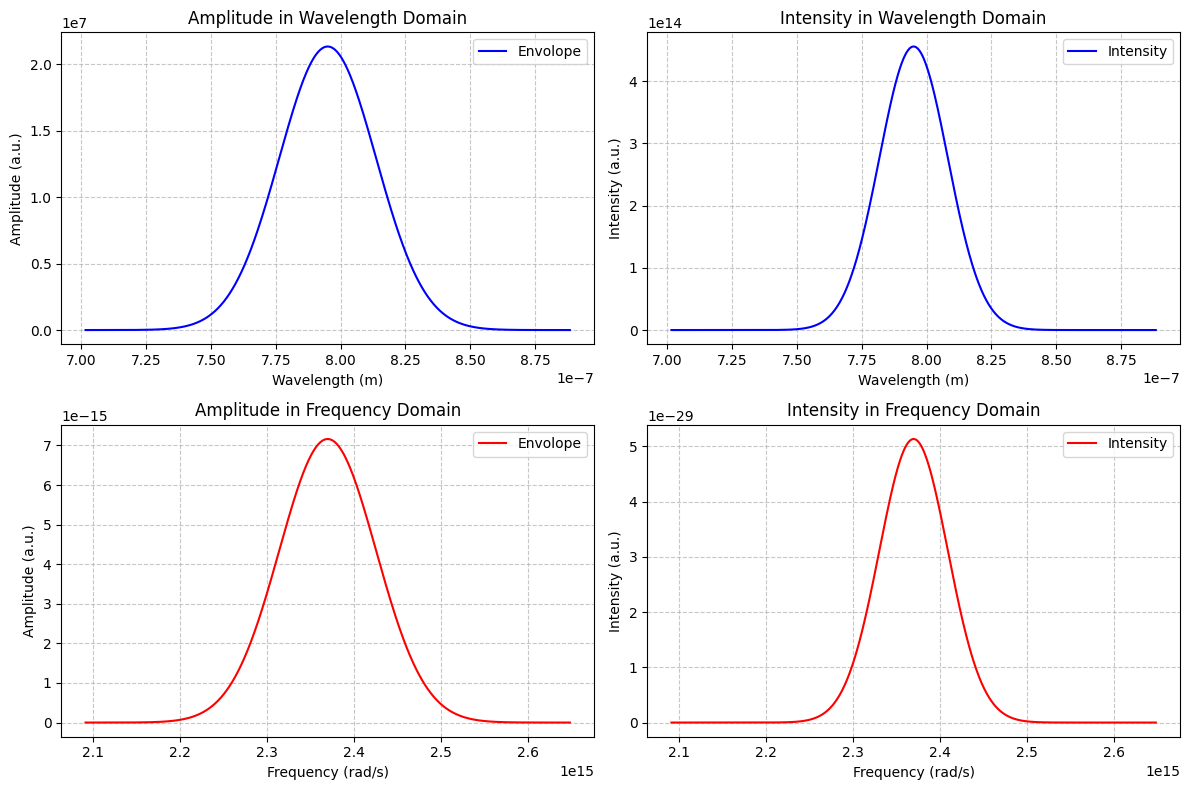

In [3]:
fig0, axs0 = plt.subplots(2, 2, figsize=(12, 8))

# Visualizacion del pulso en longitud de onda
axs0[0, 0].plot(wavelength, A_lambda, label='Envolope', color='blue')
axs0[0, 0].set_ylabel('Amplitude (a.u.)')
axs0[0, 0].set_xlabel('Wavelength (m)')
axs0[0, 0].set_title('Amplitude in Wavelength Domain')
axs0[0, 0].legend()
axs0[0, 0].grid(True, which="both", linestyle='--', alpha=0.7)

axs0[0, 1].plot(wavelength, I_lambda, label='Intensity', color='blue')
axs0[0, 1].set_ylabel('Intensity (a.u.)')
axs0[0, 1].set_xlabel('Wavelength (m)')
axs0[0, 1].set_title('Intensity in Wavelength Domain')
axs0[0, 1].legend()
axs0[0, 1].grid(True, which="both", linestyle='--', alpha=0.7)

# Visualizacion del pulso en frecuencia
axs0[1, 0].plot(frequencies, A_omega, label='Envolope', color='red')
axs0[1, 0].set_ylabel('Amplitude (a.u.)')
axs0[1, 0].set_xlabel('Frequency (rad/s)')
axs0[1, 0].set_title('Amplitude in Frequency Domain')
axs0[1, 0].legend()
axs0[1, 0].grid(True, which="both", linestyle='--', alpha=0.7)

axs0[1, 1].plot(frequencies, I_omega, label='Intensity', color='red')
axs0[1, 1].set_ylabel('Intensity (a.u.)')
axs0[1, 1].set_xlabel('Frequency (rad/s)')
axs0[1, 1].set_title('Intensity in Frequency Domain')
axs0[1, 1].legend()
axs0[1, 1].grid(True, which="both", linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 2. Cristal KTP para SHG


In [4]:
# instance of the crystal and phase matching
ktp = KTPCrystal()
pm = PhaseMatching(crystal=ktp, lambda_0_um=fundamental_wavelength_um)  # Calculate phase matching at fundamental wavelength

Lambda_um = 3.19  # Período QPM en micrómetros AFINAR VALOR DEL CRISTAL

# IMPORTANT:  the frequencies must be the ones corresponding to the second harmonic
pmf_no_qpm = pm.phase_matching_function(SHG_frequencies, L, Lambda_um=None)
pmf_with_qpm = pm.phase_matching_function(SHG_frequencies, L, Lambda_um=Lambda_um)

In [5]:
fundamental_wavelength_um 

0.795

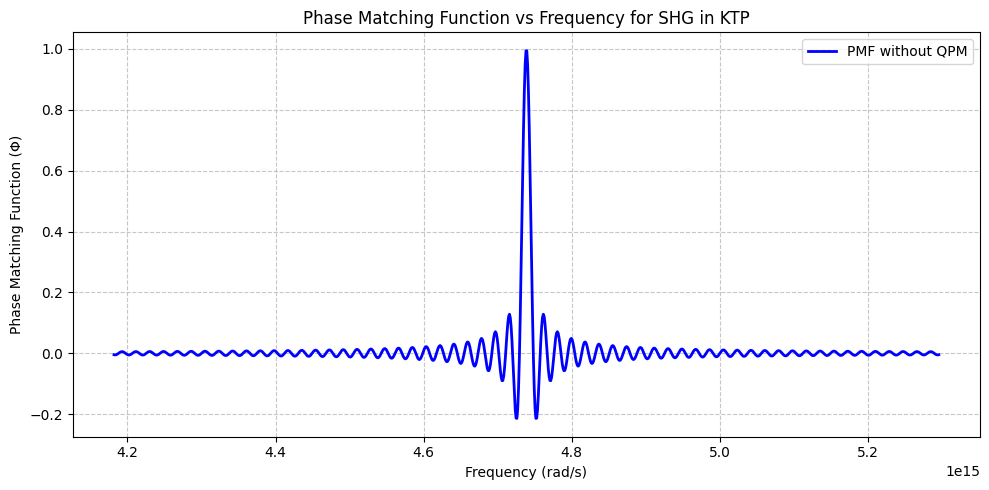

PMF at 2ω_0 (no QPM): 0.9941
PMF at 2ω_0 + 1e12 (no QPM): -0.1818


In [6]:
plt.figure(figsize=(10, 5))
plt.plot(SHG_frequencies, pmf_no_qpm, label='PMF without QPM', color='blue', linewidth=2)
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase Matching Function (Φ)')
plt.title('Phase Matching Function vs Frequency for SHG in KTP')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

# Imprimir algunos valores para verificación
print(f"PMF at 2ω_0 (no QPM): {pmf_no_qpm[len(pmf_no_qpm)//2]:.4f}")
print(f"PMF at 2ω_0 + 1e12 (no QPM): {pmf_no_qpm[len(pmf_no_qpm)//2 + 10]:.4f}")

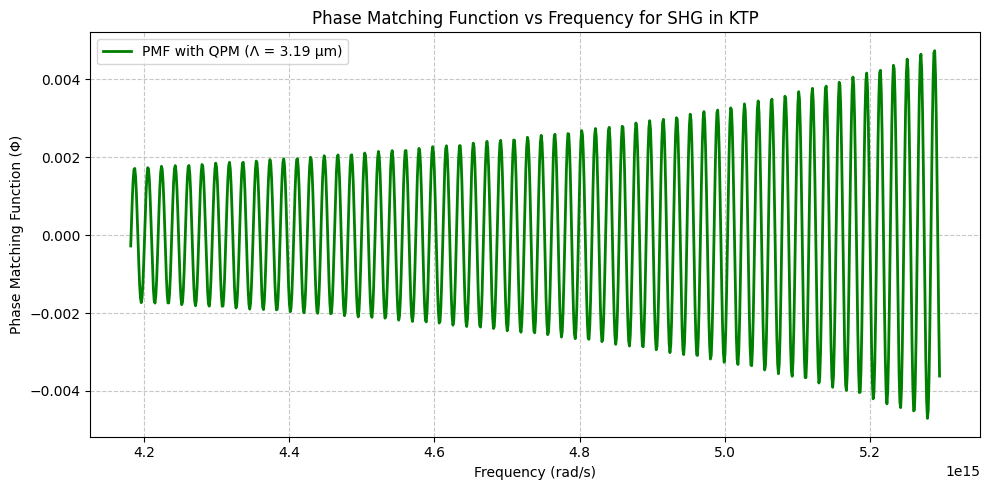

PMF at 2ω_0 (with QPM): -0.0022
PMF at 2ω_0 + 1e12 (with QPM): 0.0011


In [7]:
plt.figure(figsize=(10, 5))
plt.plot(SHG_frequencies, pmf_with_qpm, label=f'PMF with QPM (Λ = {Lambda_um} µm)', color='green', linewidth=2)
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase Matching Function (Φ)')
plt.title('Phase Matching Function vs Frequency for SHG in KTP')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

print(f"PMF at 2ω_0 (with QPM): {pmf_with_qpm[len(pmf_with_qpm)//2]:.4f}")
print(f"PMF at 2ω_0 + 1e12 (with QPM): {pmf_with_qpm[len(pmf_with_qpm)//2 + 10]:.4f}")

### 3. Covolution of the initial pulse

In [8]:
# Discrete convolution
conv_result = conv_discrete(A_omega, A_omega, frequencies)  # self-convolution
conv_frequencies = frequencies * 2  # la convolulcion dobla la frecuencia central | SHG frequencies

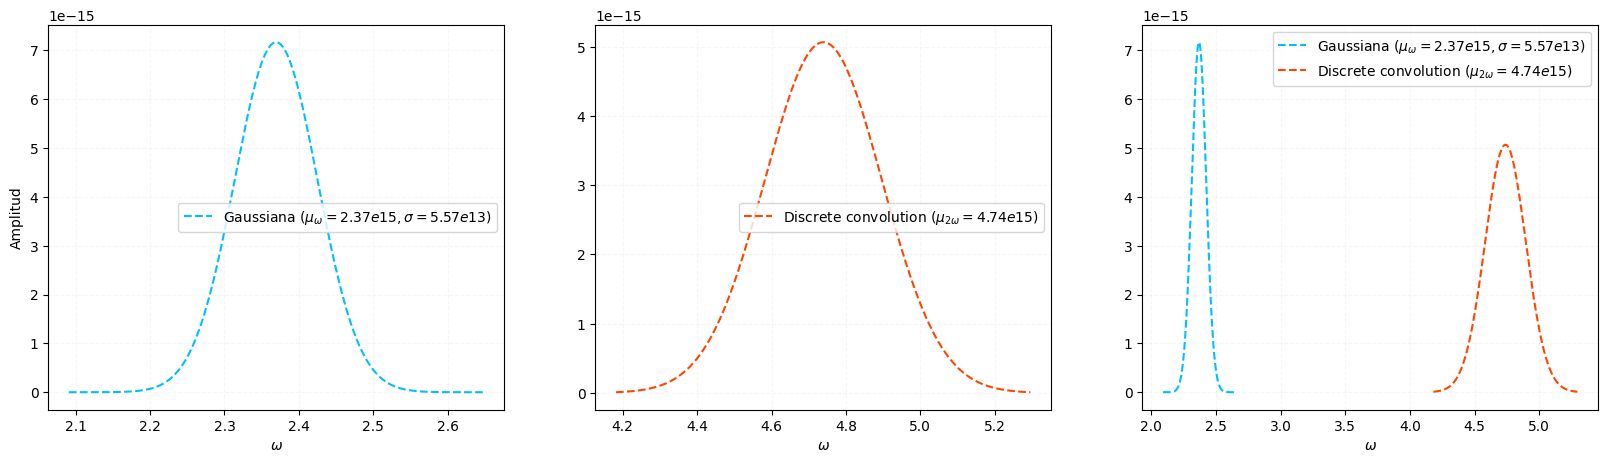

In [9]:
# --- Visualización Comparativa entrada y salida---
fig1, axs = plt.subplots(1,3,figsize=(20,5))

axs[0].plot(frequencies*1e-15, A_omega, label=r'Gaussiana ($\mu_{\omega}=2.37e15, \sigma=5.57e13$)', linestyle='--', color='deepskyblue')
axs[0].set_xlabel(r'$\omega$')
axs[0].set_ylabel('Amplitud')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.1)
axs[1].plot(SHG_frequencies*1e-15, conv_result, label=r'Discrete convolution ($\mu_{2\omega}=4.74e15$)', linestyle='--', color='orangered')
axs[1].set_xlabel(r'$\omega$')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.1)
axs[2].plot(frequencies*1e-15, A_omega, label=r'Gaussiana ($\mu_{\omega}=2.37e15, \sigma=5.57e13$)', linestyle='--', color='deepskyblue')
axs[2].plot(SHG_frequencies*1e-15, conv_result, label=r'Discrete convolution ($\mu_{2\omega}=4.74e15$)', linestyle='--', color='orangered')
axs[2].set_xlabel(r'$\omega$')

axs[2].legend()
axs[2].grid(True, linestyle='--', alpha=0.1)

### 4. Product of the convolution and the phase matching function

In [10]:
SHG_shape_with_qpm = conv_result * pmf_with_qpm  # Convolución con la función de coincidencia de fase con QPM
SHG_shape_no_qpm =conv_result * pmf_no_qpm       # Convolución con la función de coincidencia de fase sin QPM

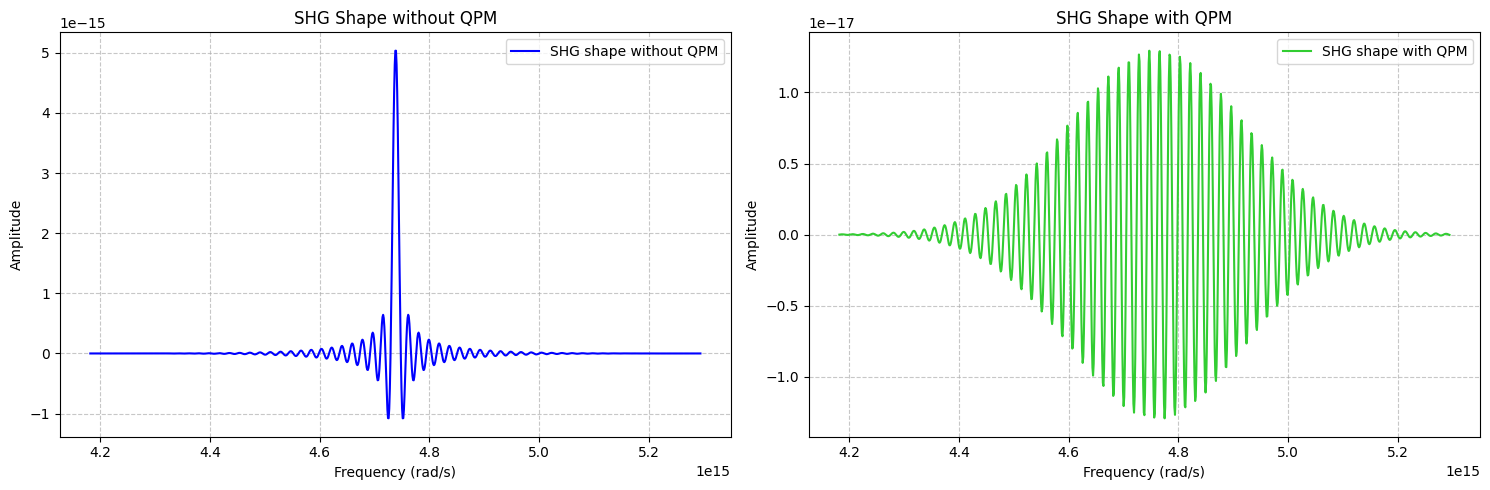

In [11]:
begin = 0
end = -1

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
SHG_frequencies_plot_interval = conv_frequencies[begin: end]
SHG_shape_no_qpm_plot_interval = SHG_shape_no_qpm[begin: end]

plt.plot(SHG_frequencies_plot_interval, SHG_shape_no_qpm_plot_interval, label='SHG shape without QPM', color='blue')
plt.xlabel('Frequency (rad/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('SHG Shape without QPM')
plt.ylabel('Amplitude')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(1, 2, 2)

SHG_frequencies_plot_interval = conv_frequencies[begin: end]
SHG_shape_with_qpm_plot_interval = SHG_shape_with_qpm[begin: end]

plt.plot(SHG_frequencies_plot_interval, SHG_shape_with_qpm_plot_interval, label='SHG shape with QPM', color='limegreen')
plt.xlabel('Frequency (rad/s)')
plt.title('SHG Shape with QPM')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

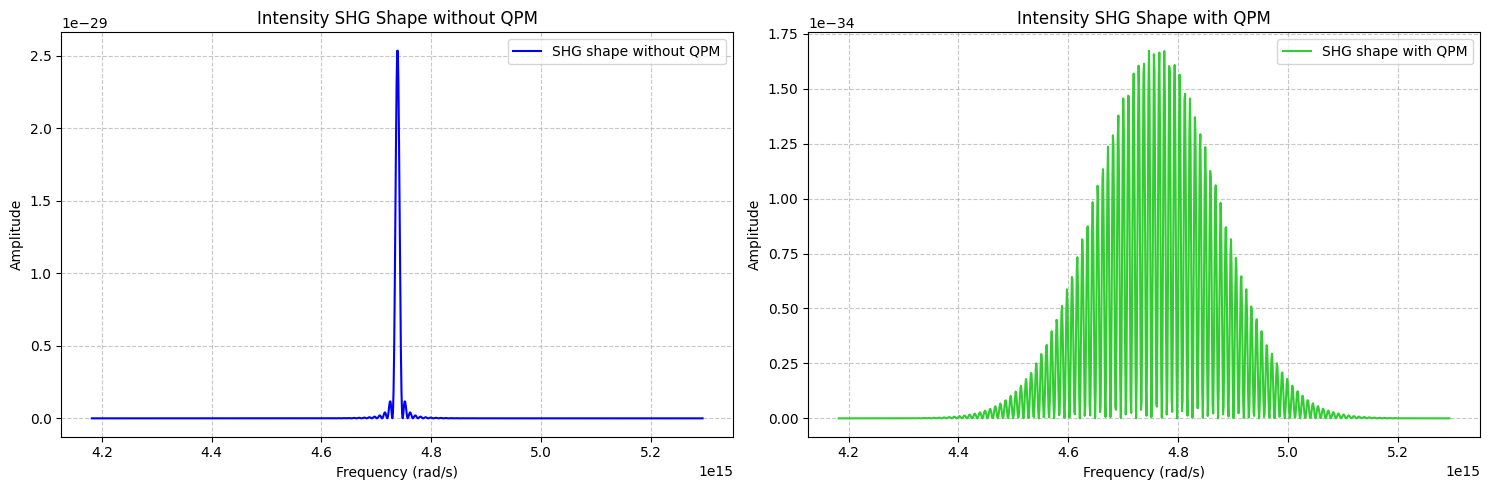

In [12]:
begin = 0
end = -1

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
SHG_frequencies_plot_interval = conv_frequencies[begin: end]
SHG_shape_no_qpm_plot_interval = SHG_shape_no_qpm[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_no_qpm_plot_interval)**2, label='SHG shape without QPM', color='blue')
plt.xlabel('Frequency (rad/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Intensity SHG Shape without QPM')
plt.ylabel('Amplitude')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(1, 2, 2)

SHG_frequencies_plot_interval = conv_frequencies[begin: end]
SHG_shape_with_qpm_plot_interval = SHG_shape_with_qpm[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_with_qpm_plot_interval)**2, label='SHG shape with QPM', color='limegreen')
plt.xlabel('Frequency (rad/s)')
plt.title('Intensity SHG Shape with QPM')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

### 5. Factor de amplitud

$$
\frac{i\omega_{0} \chi^{(2)} L}{n_{2\omega} c}G_{m}
$$

In [13]:
# at firts order Gm = 2/pi
Gm = 2/np.pi  # dimessionless
omega_0 = fundamental_frequency
L = 4e-3  # (m) | 4 mm
c = 299792458  # (m/s)
# d_eff = 15.4e-12  # (m/V) | 15.4 pm/V  # aparece en la tesis
d_eff = 27.2e-12  # (m/V) | 27.2 pm/V  # aparece en todas las otras fuentes.
chi_2 = 2 * d_eff  # (m/V)
n_2w = ktp.refractive_index(SHG_wavelength_um, axis='nz')  # dimensionless

# Calculate the magnitude of the amplitude factor
amplitude_factor_magnitude = 1j * (Gm * omega_0 * L * chi_2) / (2 * n_2w * c)

print(f"Calculated Amplitude Factor Magnitude: {amplitude_factor_magnitude:.5e}")

Calculated Amplitude Factor Magnitude: 0.00000e+00+2.78193e-07j
